In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from qutip import sigmax, sigmay, sigmaz, basis, qeye, tensor, Qobj, fock_dm
from qutip_qip.circuit import QubitCircuit, Gate
from qutip_qip.device import ModelProcessor, Model, CavityQEDModel
from qutip_qip.compiler import GateCompiler, Instruction, CavityQEDCompiler
from qutip import Options
from qutip_qip.noise import Noise

In [2]:
class ClassicalCrossTalk(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims=None, pulses=None, systematic_noise=None):
        """Adds noise to the control pulses.
        
        Args:
            dims: Dimension of the system, e.g., [2,2,2,...] for qubits.
            pulses: A list of Pulse objects, representing the compiled pulses.
            systematic_noise: A Pulse object with no ideal control, used to represent
            pulse-independent noise such as decoherence (not used in this example).
        Returns:
            pulses: The list of modified pulses according to the noise model.
            systematic_noise: A Pulse object (not used in this example). 
        """
        for i, pulse in enumerate(pulses):
            if "sx" not in pulse.label and "sy" not in pulse.label:
                continue  # filter out other pulses, e.g. drift
            target = pulse.targets[0]
            if target != 0:  # add pulse to the left neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target - 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
            if target != len(dims) - 1:  # add pulse to the right neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target + 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
        return pulses, systematic_noise

In [7]:
from joblib import Parallel, delayed
num_gates = 10
num_sample = 200
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [250]#, 500, 750] #, 1000, 1250, 1500]

num_qubits = 2
num_c_levels = 10
target_q = 1 # is the cavity included in this list? assuming ... 
"""
0 - cavity
1 - qubit 1
2 - qubit 2

qubit 2 does not receive signal directly
"""

qc = QubitCircuit(num_gates)
model = CavityQEDModel(2)

def single_crosstalk_sim(num_gates):
    proc = ModelProcessor(model=model)
    proc.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    proc.native_gates = None
    comp = CavityQEDCompiler(GateCompiler, params = model.params)

    proc.add_noise(ClassicalCrossTalk(1.0))


    gates_set = [ # what should the targets be ? Is the cavity included in the targets list?
            Gate("RX", targets=[target_q], arg_value=0), # rx
            Gate("RX", targets=[target_q], arg_value=np.pi / 2),
            Gate("RX", targets=[target_q], arg_value=np.pi),
            Gate("RX", targets=[target_q], arg_value=np.pi / 2 * 3),
    ]

    for ind in np.random.randint(0, 4, num_gates):
        qc.add_gate(gates_set[ind])

    proc.load_circuit(qc,compiler=comp)    

    init_state = tensor([qeye(num_c_levels),Qobj([[init_fid, 0], [0, 0.025]]), Qobj([[init_fid, 0], [0, 0.025]])])
    options = Options(nsteps=10000)
    e_ops = [tensor([qeye(num_c_levels), qeye(2), fock_dm(2)])]
    result = proc.run_state(init_state, e_ops=e_ops, options=options)
    result = result.expect[0][-1]
    fig, ax = proc.plot_pulses(figsize=(5, 3), dpi=120,use_control_latex=False)
    
    return result

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/qutip_qip/device/processor.py:334: DeprecationWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

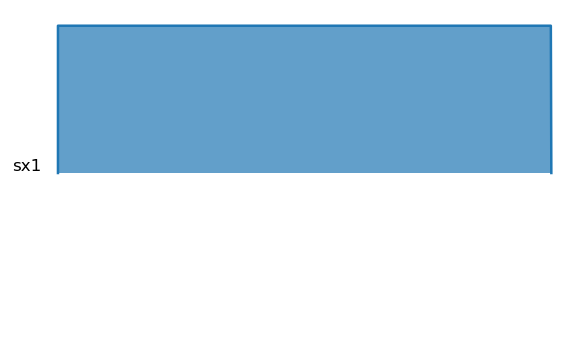

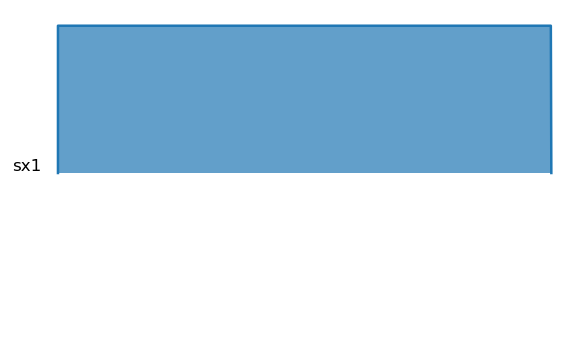

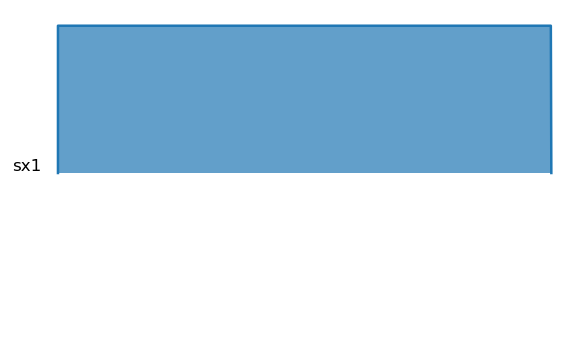

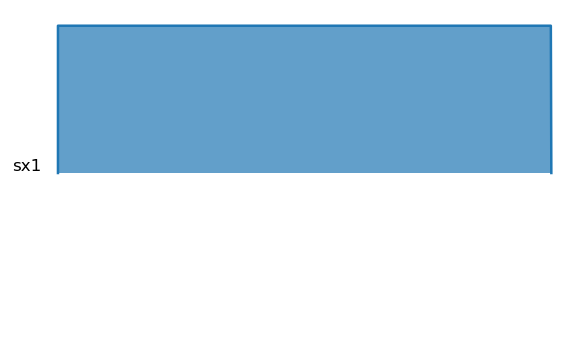

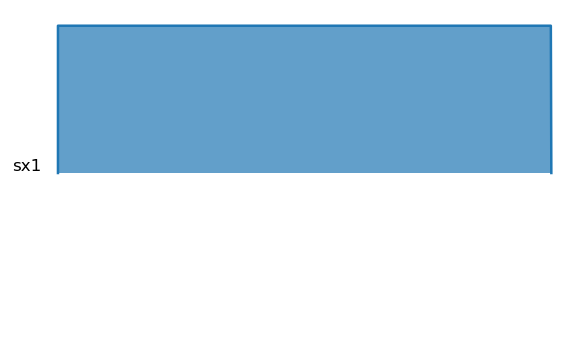

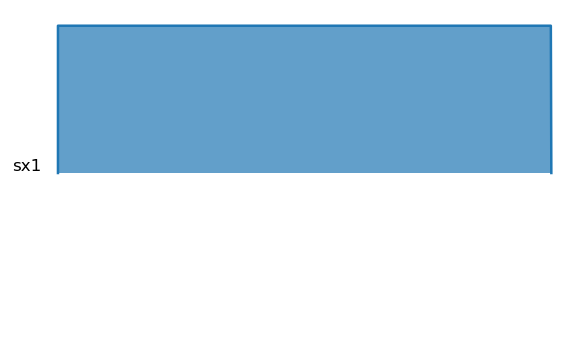

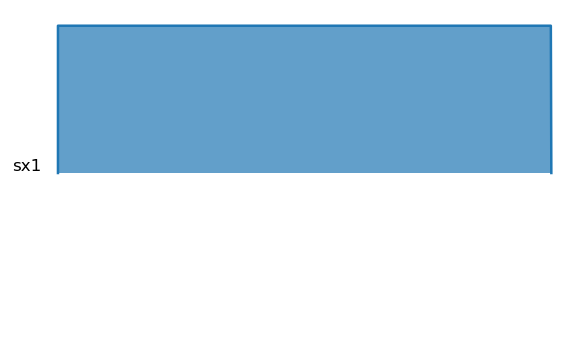

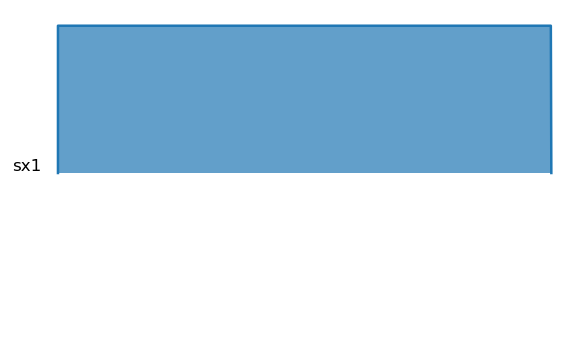

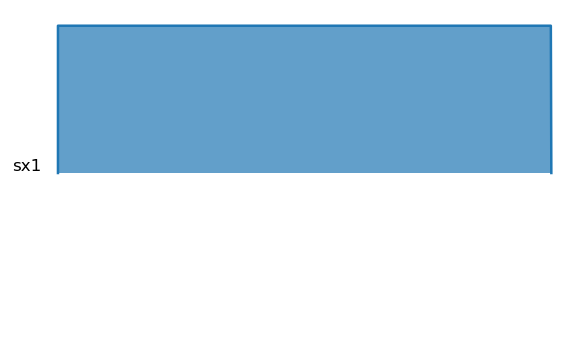

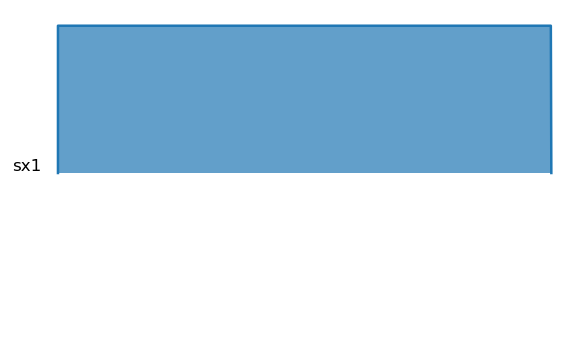

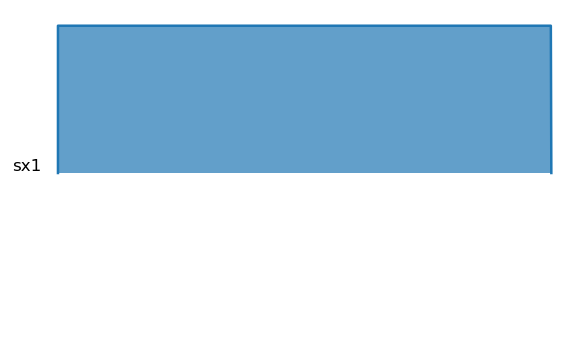

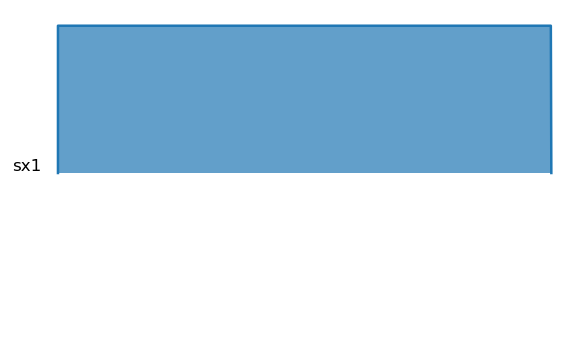

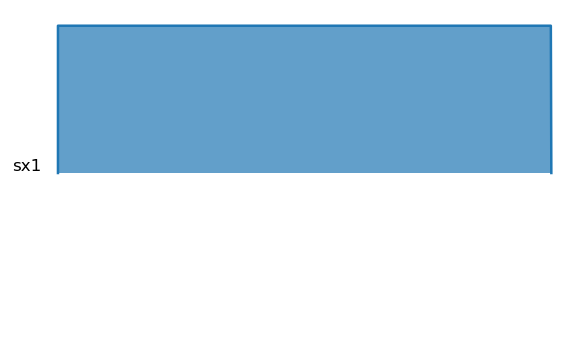

In [6]:
for num_gates in num_gates_list:
    # expect = Parallel(n_jobs=8)(delayed(single_crosstalk_simulation)(num_gates) for i in range(num_sample))
    expect = [single_crosstalk_sim(num_gates) for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect)/np.sqrt(num_sample))
# single_crosstalk_sim(num_gates) #changes based on how many times I run the program

In [ ]:
def rb_curve(x, a):
    return (1 / 2 + np.exp(-2 * a * x) / 2) * 0.975


pos, cov = curve_fit(rb_curve, num_gates_list, fidelity, p0=[0.001])

xline = np.linspace(0, 1700, 200)
yline = rb_curve(xline, *pos)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax.errorbar(
    num_gates_list, fidelity, yerr=fidelity_error, fmt=".", capsize=2, color="slategrey"
)
ax.plot(xline, yline, color="slategrey")
ax.set_ylabel("Average fidelity")
ax.set_xlabel(r"Number of $\pi$ rotations")
ax.set_xlim((0, 1700));